---
title: Figures
---

On this page you can find all figures and code to produce the figures of the manuscript. 

In [1]:
#| echo: false
#| output: false
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}
%config InlineBackend.print_figure_kwargs = {'pad_inches': 0}
check_size = False

## Introduction

### Figure 1

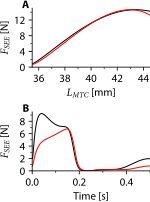

In [13]:
#| label: fig-i-effect-ksee
#| fig-cap: Effect of a 2.5-fold difference in SEE stiffness on simulated mechanical behaviour. This example shows that some 
#|   contractions may lead to similar mechanical behaviour across distinct parameter sets, others may differ substantially.

# %% Imports etc.
# Default packages
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd, '..')
dataDir = os.path.join(baseDir, 'data')
funcDir = os.path.join(baseDir, 'analysis', 'functions')
sys.path.append(funcDir)

# Custom imports ---
import cust_fig, hillmodel, make_data

# %% Load muscle parameters
mus = 'GMs1'
parFile = os.path.join(dataDir, mus, 'parameters', f'{mus}_OR.pkl')
muspar = pickle.load(open(parFile, 'rb'))
muspar['fmax'] *= 1.1  # adjust for figure scaling

musparV2 = muspar.copy()
musparV2.update({
    'lce_opt': muspar['lce_opt'] - 2.4e-3,
    'lsee0'  : muspar['lsee0']  + 1.2e-3,
    'ksee'   : muspar['ksee'] / 2,
})

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11)

fig = plt.figure(figsize=(15.92/2.54/3 +50/600, 7.34/2.54), constrained_layout=True)
gs = fig.add_gridspec(2, 1)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])
    
# %% Panel A: Force–Length relationship
lmtc = np.linspace(35.5, 44.5) * 1e-3
fsee    = hillmodel.ForceEQ(lmtc, 1, muspar)[0]
fseeV2  = hillmodel.ForceEQ(lmtc, 1, musparV2)[0]

ax = axs[0,0]
ax.plot(lmtc * 1000, fsee, 'k')
ax.plot(lmtc * 1000, fseeV2, 'r')
ax.set_xlabel(r"$L_{MTC}$ [mm]")
ax.set_ylabel("$F_{SEE}$ [N]")
ax.set_xlim(35.5, 44.5)
ax.set_ylim(0, 15)
ax.set_xticks([36, 38, 40, 42, 44], minor=False)
ax.set_xticks([37, 39, 41, 43], minor=True)
ax.set_yticks([0, 4, 8, 12], minor=False)
ax.set_yticks([2, 6, 10, 14], minor=True)

# %% Panel B: Fsee(t) during SSC
cf, fs, amp = 2, 2000, 2.5e-3
time = np.arange(0, 1/cf, 1/fs)
tStim = np.array([0.0, 1/(4*cf)])
stim = make_data.make_stim(time, *tStim)
solmat = {'time': time, 'lmtc': amp*np.cos(2*np.pi*time*cf)
          + muspar['lce_opt'] + muspar['lsee0']
          + (muspar['fmax']/muspar['ksee'])**0.5, 'tStim': tStim}

def simulate_force(params):
    gamma0 = params['gamma_0']
    lcerel0 = hillmodel.ForceEQ(solmat['lmtc'][0], gamma0, params)[1]
    return hillmodel.SolveSimuMTC(gamma0, lcerel0, params, solmat)[1][9]

ax = axs[1,0]
ax.plot(time, simulate_force(muspar), 'k')
ax.plot(time, simulate_force(musparV2), 'r')
ax.set_xlabel(r"Time [s]")
ax.set_ylabel(r"$F_{SEE}$ [N]")
ax.set_xlim(0, 1/cf)
ax.set_ylim(0, 9.5)
ax.set_xticks([0, 0.2, 0.4])
ax.set_xticks([0.1, 0.3, 0.5], minor=True)
ax.set_yticks([0, 2, 4, 6, 8])
ax.set_yticks([1, 3, 5, 7, 9], minor=True)

cust_fig.add_labels(fig, axs.flatten(), ['A', 'B'])
fig.align_labels()

# %% Save and display
plt.show()
fig.savefig('i_effect_ksee.pdf', bbox_inches='tight', pad_inches=0)
fig.savefig('i_effect_ksee.svg', bbox_inches='tight', pad_inches=0)

# %% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("i_effect_ksee.pdf") 
    cust_fig.report_fig_size("i_effect_ksee.svg") 


## Methods

### Figure 2

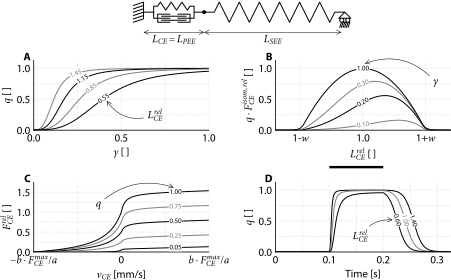

In [3]:
#| label: fig-m-hill-model
#| fig-cap: Aspects of the Hill-type MTC model used, illustrated at the top. 
#|   $L_{CE}$, $L_{PEE}$ and $L_{SEE}$ denote the CE, parallel elastic 
#|   element (SEE) and serial elastic element (SEE) length. CE represents 
#|   the contractile part of the muscle fibres, while PEE and SEE represent 
#|   all elastic tissue in parallel or in series, respectively, with CE. In 
#|   the Hill-type MTC model, CE force depends on active state (A), CE length 
#|   (B) and CE velocity (C). The effect of CE stimulation on active state 
#|   ($q$) is illustrated in D. A) The relationship between normalised free 
#|   $Ca^{2+}$ concentration between the myofilaments ($\gamma$) and $q$. 
#|   $q$ also depends on relative CE length ($L_{CE}^{rel}$). B) The product 
#|   of $q$ and the normalised active CE force-length relationship for 
#|   different values of $\gamma$. C) The CE force-velocity relationship for 
#|   different values of $q$. D) $q$ over time before, during and after CE 
#|   stimulation for $L_{CE}^{rel}=1$. CE stimulation is maximal during the 
#|   period indicated by the black bar and ‘off’ elsewhere.

# %% Imports etc.
import sys, os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, hillmodel

# %% Load muscle parameters
mus = 'GMs1'
parFile = os.path.join(dataDir,mus,'parameters',mus+'_OR.pkl')
muspar = pickle.load(open(parFile, 'rb'))

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=(15.92/2.54+50/600, (15.92/3*2-0.5)/2.54), constrained_layout=True) # 2:1 ratio (3761px x 1880px)
gs = fig.add_gridspec(4, 2,height_ratios=[10/1.5, 10, 1/2.9, 10], hspace=0)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])
axs[0,0].remove(); axs[0,1].remove(); 
axs[0,0] = fig.add_subplot(gs[0, :])
axs[2,0].remove(); 

# %% Panel 0: Schematic MTC model
data = pd.read_csv("m_mtc_data.txt", sep=',')
x = data.to_numpy()[:,0]
y = data.to_numpy()[:,1]
n = 35 # endpoint CE

ax = axs[0,0]
ax.set_axis_off()
ax.plot(x,y,'k',lw=1)
ax.plot(x[n],y[n],'k',marker='.')
ax.plot(np.array([0,x[0]]),np.array([0,y[0]]),'k')
ax.annotate('', xy=(0,-10), xycoords='data', xytext=(x[n], -10), arrowprops=dict(arrowstyle="<->", lw=0.5, shrinkA = 0, shrinkB = 0))
ax.text(x[n]/2,-16, "$L_{CE} = L_{PEE}$", color="k",ha="center", va = 'bottom') # else part of xlabel is cropped..
ax.annotate('', xy=(x[n],-10), xycoords='data', xytext=(x[-1], -10), arrowprops=dict(arrowstyle="<->", lw=0.5, shrinkA = 0, shrinkB = 0))
ax.text((x[-1]-x[n])/2+x[n],-16, "$L_{SEE}$", color="k",ha="center", va = 'bottom') # else part of xlabel is cropped..
ax.plot([0,0],[-16,-16], alpha=0)
ax.axis('equal')
ax.autoscale(enable=True, axis='x', tight=True)

# %% Panel A: q(gamma)
ax = axs[1,0]

n = 101
gamma = np.linspace(muspar['gamma_0'],1,n)
qlijn = -gamma*2.5+1.5;
for iL,lcerel in enumerate([1.45,1.15,0.85,0.55]):
    if iL%2 == 0:
        clr = "gray"
    else:
        clr = "k" # gray if we want to switch..
    q = hillmodel.ActState(gamma,np.repeat(lcerel,n),muspar)[0]
    l, = ax.plot(gamma,q,color=clr)
    idx = np.argmin(np.abs(q-qlijn))
    angle = np.rad2deg(np.arctan2(np.gradient(q,gamma)[idx], 1))
    ax.text(gamma[idx], q[idx], '{:.2f}'.format(lcerel), ha='center', va='center', fontsize = 7, color = clr,
                 transform_rotates_text=True, rotation=angle, bbox=dict(ec='1', fc='1', pad=0.1))
   
ax.annotate('$L_{CE}^{rel}$', xy=(gamma[idx]+0.01, q[idx]-0.01), xycoords='data', xytext=(42, -19), 
                textcoords='offset points', arrowprops=dict(arrowstyle="->",lw=0.5, connectionstyle="arc3,rad=-.4"))
ax.set_xlabel(r"$\gamma$ [ ]")
ax.set_ylabel(r"$q$ [ ]")
ax.set_xlim(0,1)
ax.set_ylim(0,1.125)
ax.set_xticks([0.0,0.25,0.5,0.75,1.0])
ax.set_xticklabels(["0.0","","0.5","","1.0"])
ax.set_yticks([0.0,0.25,0.5,0.75,1.0])
ax.set_yticklabels(["0.0","","0.5","","1.0"])

# %% Panel B: fisomrel(lcerel,q) ---
ax = axs[1,1]
lcerel = np.linspace(0,2,n)
fisomrel = hillmodel.ForceLength(lcerel,muspar)[0]

idx = np.argmin(np.abs(lcerel-1))
for iGam,gamma in enumerate([0.10,0.20,0.30,1.00]):
    if iGam%2 == 0:
        clr = "gray"
    else:
        clr = "k" # gray if we want to switch..
    q = hillmodel.ActState(gamma,lcerel,muspar)[0]
    ax.plot(lcerel,q*fisomrel,color=clr)
    angle = np.rad2deg(np.arctan2(np.gradient(q,lcerel)[idx], 1))
    ax.text(lcerel[idx],q[idx], '{:.2f}'.format(gamma), ha='center', va='center', fontsize = 7, color=clr,
                  transform_rotates_text=True, rotation=angle, bbox=dict(ec='1', fc='1', pad=0.1))

ax.annotate(r'$\gamma$', xy=(lcerel[idx],q[idx]+0.07), xycoords='data', xytext=(70, -20), 
                textcoords='offset points', arrowprops=dict(arrowstyle="->", lw=0.5, connectionstyle="arc3,rad=.35"), annotation_clip=True)
ax.set_xlabel(r"$L_{CE}^{rel}$ [ ]")
ax.set_xticks([muspar['w'],1,1+muspar['w']])
ax.set_xticklabels(["1-$w$","1.0","1+$w$"])
ax.set_xlim(0.3,1.7)

ax.set_ylabel(r"$q \cdot F_{CE}^{isom,rel}$ [ ]")
ax.set_yticks([0.0,0.25,0.5,0.75,1.0])
ax.set_yticklabels(["0.0","","0.5","","1.0"])
ax.set_ylim(0,1.125)

# %% Panel C: fcerel(vcerel)
ax = axs[3,0]

lcerel = np.repeat(1,n)
fisomrel = hillmodel.ForceLength(lcerel,muspar)
# vcerel = np.linspace(-muspar['brel']/muspar['arel'],muspar['brel']/muspar['arel'],n)
# fcerel = np.linspace(0,1.5,n)*idx
fce = np.linspace(0,1.5,n)*muspar['fmax']

vce = np.linspace(-muspar['b']/muspar['a'],muspar['b']/muspar['a'],n)*muspar['fmax']
qs = [0.05,0.25,0.50,0.75,1.00]
idx = n-20
for iFV,q in enumerate(qs):
    if iFV%2 == 0:
        clr = "k"
    else:
        clr = "gray" # gray if we want to switch..
    fce,fcerel = hillmodel.Vce2Fce(vce,q,1,muspar)[0:2]
    ax.plot(vce,fcerel,color=clr)
    ax.text(vce[idx],fcerel[idx], '{:.2f}'.format(q), ha='center', va='center', fontsize = 7, color=clr,
                  transform_rotates_text=True, rotation=angle, bbox=dict(ec='1', fc='1', pad=0.1))

ax.annotate('$q$', xy=(vce[idx],fcerel[idx]+0.1), xycoords='data', xytext=(-80, -18.5), 
                textcoords='offset points', arrowprops=dict(arrowstyle="->",lw=0.5, connectionstyle="arc3,rad=-.3"),annotation_clip=False)

ax.set_xlabel(r'$v_{CE}$ [mm/s]')
ax.set_xticks([-muspar['b']*muspar['fmax']/muspar['a'],-0.5*muspar['b']*muspar['fmax']/muspar['a'],0,0.5*muspar['b']*muspar['fmax']/muspar['a'],muspar['b']*muspar['fmax']/muspar['a']])
ax.set_xticklabels([r"$\frac{-b \cdot F_{CE}^{max}}{a}$","","0","",r"$\frac{b \cdot F_{CE}^{max}}{a}$"])
ax.set_xticklabels([r"$-b \cdot F_{CE}^{max}/a$","","0","",r"$b \cdot F_{CE}^{max}/a$"])
ax.set_xlim(-muspar['b']*muspar['fmax']/muspar['a'],muspar['b']*muspar['fmax']/muspar['a'])

ax.set_ylabel(r"$F_{CE}^{rel}$ [ ]")
ax.set_yticks([0.0,0.25,0.5,0.75,1.0,1.25,1.5])
ax.set_yticklabels(["0.0","","0.5","","1.0",'','1.5'])
ax.set_ylim(0,1.75)

# %% Panel D: q(t)
ax = axs[3,1]
def Solve(t,gamma,parms,tStim):  
    stim = ((t>=tStim[0]) & (t<tStim[1]))*1
    
    gamma_0 = parms['gamma_0'];
    gammad = (stim>=gamma)*((stim*(1-gamma_0)-gamma + gamma_0)/parms['tact']) + (stim<gamma)*((stim*(1-gamma_0)-gamma + gamma_0)/parms['tdeact']);
    return gammad, stim

state0 = [muspar['gamma_0']]
n = 81
tspan = [0, 0.5]
tStim = [0.1,0.2]

fun = lambda t, x: Solve(t,x,muspar,tStim)[0]
sol = solve_ivp(fun,tspan,state0,method='RK45',max_step=1e-3,rtol=1e-4,atol=1e-8)
stim = Solve(sol.t,sol.y,muspar,tStim)[1]
time = sol.t; gamma = sol.y[0];

n = len(gamma)
# q = ActState(gamma,1,muspar)[0]

for iL,lcerel in enumerate([1.4,1.0,0.6]):
    if iL%2 == 0:
        clr = "k"
    else:
        clr = "gray" # gray if we want to switch..
    q = hillmodel.ActState(gamma,lcerel,muspar)[0]
    ax.plot(time,q,color=clr)
    
    idx = np.argmin(np.abs(q[200:]-0.5))+200
    angle = np.rad2deg(np.arctan2(np.gradient(q,time)[idx], 1))
    ax.text(time[idx],q[idx], '{:.2f}'.format(lcerel), ha='center', va='center', fontsize = 7, color=clr,
                  transform_rotates_text=True, rotation=angle, bbox=dict(ec='1', fc='1', pad=0.1))

ax.annotate('$L_{CE}^{rel}$', xy=(time[idx]-0.005, q[idx]), xycoords='data', xytext=(-42, -19), 
                textcoords='offset points', arrowprops=dict(arrowstyle="->",lw=0.5, connectionstyle="arc3,rad=-.3"))

ax.set_xlabel(r"Time [s]")
ax.set_ylabel(r"$q$ [ ]")

ax.set_xlim(0,0.325)
ax.set_ylim(0,1.125)
ax.set_xticks([0,0.05,0.10,0.15,0.20,0.25,0.3]);
ax.set_xticklabels(["0","","0.1","","0.2",'','0.3'])
ax.set_yticks([0.0,0.25,0.5,0.75,1.0])
ax.set_yticklabels(["0.0","","0.5","","1.0"])

# %% STIM bar of Panel D
ax = axs[2,1]
import matplotlib.patches as patches
from matplotlib.path import Path
verts = [
   (tStim[0], 0.99),  # left, bottom
   (tStim[0], 1.01),  # left, top
   (tStim[1], 1.01),  # right, top
   (tStim[1], 0.99),  # right, bottom
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
]

path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='k', lw=0)
ax.add_patch(patch)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([]);
ax.set_yticks([]); 
ax.set_xlim(0,0.325)
ax.set_ylim(0.98,1.02)
ax.autoscale(enable=True, axis='y', tight=True)

cust_fig.add_labels(fig, axs.flatten(), ['','','A','B','','','C','D'])
axs[2,1].label = 'STIM bar'

# %% Save and display
plt.show()
fig.savefig("m_hill_model.svg", bbox_inches="tight", pad_inches=0)
fig.savefig("m_hill_model.pdf", bbox_inches="tight", pad_inches=0)

#%% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("m_hill_model.svg")  
    cust_fig.report_fig_size("m_hill_model.pdf") 

### Figure 3

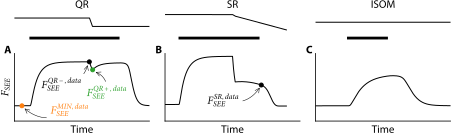

In [4]:
#| label: fig-m-protocols
#| fig-cap: |
#|   Example of simulated data of quick-release (A), step-ramp (B) and isometric (C) experiments.** Top: MTC length over 
#|   time. Bottom: SEE force over time. CE stimulation is maximal during the period indicated by the black bar, and ‘off’ 
#|   elsewhere. For each experiment, we obtained specific datapoints of SEE force and the corresponding MTC length, 
#|   which were used to estimate contraction and excitation dynamics parameter values. 

# %% Imports
import glob, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, helpers, mp_estimator

# %% Load muscle parameters
mus = 'GMs1'
parFile = os.path.join(dataDir,mus,'parameters',mus)
dataDirMus = os.path.join(dataDir,mus,'dataExp','')

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=False)

fig = plt.figure(figsize=((15.92/2.54)+50/600, (15.92/3-0.32)/2.54), constrained_layout=True) # 3:1 ratio
gs = fig.add_gridspec(3,3,height_ratios=[1,1/6.0,4])
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])

colorSet = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorSet[0] = '#000000'

# %% QR exp
iFile = 5
files = sorted(glob.glob(dataDirMus+'QR/'+mus+r'*.csv'))
filepath = files[iFile]
data = pd.read_csv(filepath).T.to_numpy()
time, lmtc, stim, fsee = data[0:4]
_,tStimOn,tStimOff = helpers.get_stim(time,stim)

# Get selection of data
optsQR = {
    'dataDir':          dataDirMus+'QR',
    'iCols':            (0,1,3),
    'idxQRmin':         'auto',
    'idxQRpre':         'auto',
    'idxQRpst':         'auto',
    'nQRsamp':          'auto',
    'dispFig':          False,
    }
_,idxQRmin,idxQRpre,idxQRpst = mp_estimator.loaddata.qr(optsQR)

# Select interesting part of data
iOn = np.argmin(abs(time-tStimOn[0]+0.05))
iOff = np.argmin(abs(time-tStimOff[-1]-0.1))
iSel = slice(iOn,iOff)
time = time[iSel]-time[iSel][0]
lmtc = lmtc[iSel]
stim = stim[iSel]
fsee = fsee[iSel]
tStimOff = tStimOff[0]-tStimOn[0]+0.05
tStimOn = tStimOn[0]-tStimOn[0]+0.05
idxQRpre = int(np.mean(np.arange(idxQRpre[iFile][0]-iOn,idxQRpre[iFile][-1]-iOn)))
idxQRpst = int(np.mean(np.arange(idxQRpst[iFile][0]-iOn,idxQRpst[iFile][-1]-iOn)))
tQRpre = time[idxQRpre]
tQRpst = time[idxQRpst]
fQRpre = fsee[idxQRpre]
fQRpst = fsee[idxQRpst]
lQRpre = lmtc[idxQRpre]
lQRpst = lmtc[idxQRpst]

# Plot lmtc(t)
ax = axs[0,0]
ax.plot(time,lmtc,'k')
ax.set_ylim(lmtc.min()-1e-4,lmtc.max()+1e-4)
ax.set_axis_off()

# Plot stim(t)
ax = axs[1,0]
verts = [
   (tStimOn, 0.99),  # left, bottom
   (tStimOn, 1.01),  # left, top
   (tStimOff, 1.01),  # right, top
   (tStimOff, 0.99),  # right, bottom
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
]

path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='k', lw=0)
ax.add_patch(patch)
ax.set_ylim(0.98,1.02)
ax.set_axis_off()
ax.autoscale(enable=True, axis='y', tight=True)

# Plot fsee(t)
ax = axs[2,0]
ax.plot(time,fsee,'k')
ax.set_xticks([])
ax.set_ylim(0,np.max(fsee))
ax.set_yticks([])

# Mark time-stances of data selection
ax.plot(0.025,fsee[50],'.',color=colorSet[1],markersize=8)
ax.plot(tQRpre,fQRpre,'.',color=colorSet[0],markersize=8)
ax.plot(tQRpst,fQRpst,'.',color=colorSet[2],markersize=8)
ax.annotate(r'$F_{SEE}^{MIN,data}$', xy=(0.025+0.004,fsee[50]-0.4), xycoords='data', xytext=(0.12, -2), 
                textcoords='data', arrowprops=dict(arrowstyle="->", lw=0.5, connectionstyle="arc3,rad=-0.4"), color= colorSet[1])
ax.annotate(r'$F_{SEE}^{QR-,data}$', xy=(tQRpre-0.004,fQRpre-0.4), xycoords='data', xytext=(tQRpre-0.16, fQRpre-7), 
                textcoords='data', arrowprops=dict(arrowstyle="->", lw=0.5, connectionstyle="arc3,rad=0.4"), color=colorSet[0])
ax.annotate(r'$F_{SEE}^{QR+,data}$', xy=(tQRpst+0.004,fQRpst-0.4), xycoords='data', xytext=(tQRpst-0.02, fQRpst-7), 
                textcoords='data', arrowprops=dict(arrowstyle="->", lw=0.5, connectionstyle="arc3,rad=0.4"), color=colorSet[2])

# Axis limits
axs[0,0].set_xlim(0,time[-1])
axs[1,0].set_xlim(0,time[-1])
axs[2,0].set_xlim(0,time[-1])

# %% SR exp
iFile = 3
files = sorted(glob.glob(dataDirMus+'SR/'+mus+r'*.csv'))
filepath = files[iFile]
data = pd.read_csv(filepath).T.to_numpy()
time, lmtc, stim, fsee = data[0:4]
_,tStimOn,tStimOff = helpers.get_stim(time,stim)

dataDirMus = os.path.join(dataDir,mus,'dataExp','')
parFile = os.path.join(dataDir,mus,'Parameters',mus)

# Get selection of data
optsSR = {
    'dataDir':          dataDirMus+'QR',
    'iCols':            (0,1,3),
    'idxQRmin':         'auto',
    'idxQRpre':         'auto',
    'idxQRpst':         'auto',
    'nQRsamp':          'auto',
    'dispFig':          False,
    }
_,idxSRcon = mp_estimator.loaddata.sr(optsSR)

# Select interesting part of data
iOn = np.argmin(abs(time-tStimOn[0]+0.05))
iOff = np.argmin(abs(time-tStimOff[-1]-0.1))
iSel = slice(iOn,iOff)
time = time[iSel]-time[iSel][0]
lmtc = lmtc[iSel]
stim = stim[iSel]
fsee = fsee[iSel]
tStimOff = tStimOff[0]-tStimOn[0]+0.05
tStimOn = tStimOn[0]-tStimOn[0]+0.05
idxSRcon = int(np.mean(np.arange(idxSRcon[iFile][0]-iOn,idxSRcon[iFile][-1]-iOn)))
tSRcon = time[idxSRcon]
fSRcon = fsee[idxSRcon]
lSRcon = lmtc[idxSRcon]

# Plot lmtc(t)
ax = axs[0,1]
ax.plot(time,lmtc,'k')
ax.set_axis_off()

# Plot stim(t)
ax = axs[1,1]
verts = [
   (tStimOn, 0.99),  # left, bottom
   (tStimOn, 1.01),  # left, top
   (tStimOff, 1.01),  # right, top
   (tStimOff, 0.99),  # right, bottom
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
]

path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='k', lw=0)
ax.add_patch(patch)
ax.set_ylim(0.98,1.02)
ax.set_axis_off()
ax.autoscale(enable=True, axis='y', tight=True)

# Plot fsee(t)
ax = axs[2,1]
ax.plot(time,fsee,'k')
ax.set_xticks([])
ax.set_ylim(0,np.max(fsee))
ax.set_yticks([])

# Mark time-stances of data selection
ax.plot(tSRcon,fSRcon,'.',color=colorSet[0],markersize=8)
ax.annotate(r'$F_{SEE}^{SR,data}$', xy=(tSRcon-0.002,fSRcon-0.25), xycoords='data', xytext=(tSRcon-0.2,fSRcon-5), 
                textcoords='data', arrowprops=dict(arrowstyle="->", lw=0.5, connectionstyle="arc3,rad=.39"), color=colorSet[0])

# %% Isom exp
iFile = 6
files = sorted(glob.glob(dataDirMus+'ISOM/'+mus+r'*.csv'))
filepath = files[iFile]
data = pd.read_csv(filepath).T.to_numpy()
time, lmtc, stim, fsee = data[0:4]
_,tStimOn,tStimOff = helpers.get_stim(time,stim)

dataDirMus = os.path.join(dataDir,mus,'dataExp','')
parFile = os.path.join(dataDir,mus,'Parameters',mus)

# Get selection of data
optsISOM = {
    'dataDir':          dataDirMus+'ISOM',
    'iCols':            (0,1,3,2),
    'durStimOffset':    0.1,
    'dispFig':          False,
    }
_, idxSEL = mp_estimator.loaddata.isom(optsISOM)

# Select interesting part of data
iOn = np.argmin(abs(time-tStimOn[0]+0.05))
iOff = np.argmin(abs(time-tStimOff[-1]-0.1))
iSel = slice(iOn,iOff)
time = time[iSel]-time[iSel][0]
lmtc = lmtc[iSel]
stim = stim[iSel]
fsee = fsee[iSel]
tStimOff = tStimOff[0]-tStimOn[0]+0.05
tStimOn = tStimOn[0]-tStimOn[0]+0.05

# Plot lmtc(t)
ax = axs[0,2]
ax.plot(time,lmtc,'k')
ax.set_axis_off()

# Plot stim(t)
ax = axs[1,2]
verts = [
   (tStimOn, 0.99),  # left, bottom
   (tStimOn, 1.01),  # left, top
   (tStimOff, 1.01),  # right, top
   (tStimOff, 0.99),  # right, bottom
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
]

path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='k', lw=0)
ax.add_patch(patch)
ax.set_ylim(0.98,1.02)
ax.set_axis_off()
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xticks([])
ax.set_yticks([])

# Plot fsee(t)
ax = axs[2,2]
ax.plot(time,fsee,'k')
ax.set_xticks([])
ax.set_ylim(0,np.max(fsee))

# %% Labels etc.
# Xlim
axs[0,2].set_xlim(0,time[-1])
axs[1,2].set_xlim(0,time[-1])
axs[2,2].set_xlim(0,time[-1])

# Titles
axs[0,0].set_title('QR')
axs[0,1].set_title('SR')
axs[0,2].set_title('ISOM')

# Labels
axs[2,0].set_xlabel('Time')
axs[2,1].set_xlabel('Time')
axs[2,2].set_xlabel('Time')
axs[2,0].set_ylabel(r'$F_{SEE}$')

# Set y-range similar
axs[2,0].set_ylim(-4,14)
axs[2,1].set_ylim(-4,14)
axs[2,2].set_ylim(-4,14)

# SR
axs[0,1].set_xlim(0,0.5)
axs[1,1].set_xlim(0,0.5)
axs[2,1].set_xlim(0,0.5)
axs[2,1].set_xticks([])
axs[2,2].set_yticks([])

labels = ['A', 'B', 'C']
cust_fig.add_labels(fig,axs[2,:],labels)

# %%  Save and display
plt.show()        
fig.savefig('m_protocols.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('m_protocols.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("m_protocols.svg")
    cust_fig.report_fig_size("m_protocols.pdf")

### Figure 4

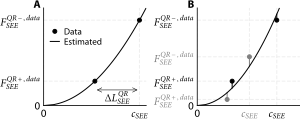

In [5]:
#| label: fig-m-ksee
#| fig-cap: |
#|   Graphical illustration of SEE stiffness parameter estimation. For each quick-release experiment, SEE force 
#|   before ($F_{SEE}^{QR-,data}$) and after ($F_{SEE}^{QR+,data}$) the quick-release was obtained from the 
#|   data, as well as the corresponding decrease in SEE length ($\Delta L_{SEE}^{QR}$). Since SEE length prior 
#|   to the quick-release is typically unknown, a temporary parameter ($c_{SEE}$) was introduced for each 
#|   experiment to represent the difference between SEE length before the quick-release and SEE slack length. 
#|   A) A single quick-release experiment yields two unknowns: $c_{SEE}$ and a parameter that scales SEE stiffness 
#|   ($k_{SEE}$). B) Running multiple quick-release experiments  yields n+1 unknowns: n values of $c_{SEE}$ (one 
#|   for each experiment) and the parameter scaling SEE stiffness. Here, two quick-release experiments are 
#|   illustrated (one indicated with black dots, the other with grey dots), while the estimated SEE force-length 
#|   relationship is depicted with the black line.

# %% Imports etc.
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, mp_estimator

# %% Load muscle parameters
mus = 'GMs1'
parFile = os.path.join(dataDir,mus,'parameters',mus+'_OR.pkl')
muspar = pickle.load(open(parFile, 'rb'))

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=((15.92/3*2)/2.54+50/600, (15.92/2-3.534)/2.54), constrained_layout=True) # 3:1 ratio
gs = fig.add_gridspec(1,2)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])

# Panel A: Fsee(Lsee) of one exp
ax = axs[0,0]
   
lseeBS = np.array([30])
lseeAS = np.array([29])
 
fseeBSdata = np.array([7])
fseeASdata = np.array([2])
        
lseeDeltaStep = lseeAS-lseeBS
kseeIndv = ((np.sqrt(fseeASdata) - np.sqrt(fseeBSdata))/(lseeDeltaStep))**2
ksee1 = np.mean(kseeIndv)

lseeoffset = (fseeBSdata/np.mean(kseeIndv))**(1/2)
seePar0 = np.insert(lseeoffset,0,np.mean(kseeIndv))
fun = lambda x: mp_estimator.objectives.cstfnc_see(x,lseeDeltaStep,fseeBSdata,fseeASdata,muspar)[0]
seeParA = optimize.fmin(fun,seePar0,maxfun=1e7,ftol=1e-6, disp=False)

fseeMdl = np.linspace(0,8,100)
lsee = (fseeMdl/seeParA[0])**(1/2)
l1,*_ = ax.plot(lsee,fseeMdl,color=[0,0,0],linestyle='-')
p1,*_ = ax.plot(seeParA[1],fseeBSdata,'k.',seeParA[1]+lseeDeltaStep,fseeASdata,'k.',markersize=8)

xs = seeParA[1]+lseeDeltaStep[0]
xs = xs/2.3
xe = seeParA[1]
xe = xe/2.3
xm = (xs+xe)/2

ax.annotate('', xy=(xs, 0.16), xycoords='axes fraction', xytext=(xe, 0.16),
            arrowprops=dict(arrowstyle="<->", lw=0.5, color='k'))
ax.annotate(r'$\Delta L_{SEE}^{QR}$', xy=(xm, 0.15), xycoords='axes fraction', ha="center", va="top")

ax.set_xlim(0,2.3)
ax.set_xticks([0,seeParA[1],seeParA[1]+lseeDeltaStep[0]])
ax.set_xticklabels([r'0','',r'$L_{SEE}^{offset}$'])
ax.set_xticks([])

ax.set_ylim(0,8)
ax.set_yticks([])
ax.set_ylabel('$F_{SEE}$')
ax.set_ylabel('')
ax.set_yticks([0,fseeBSdata[0],fseeASdata[0]])
ax.set_yticklabels(['0',r'$F_{SEE}^{QR-,data}$',r'$F_{SEE}^{QR+,data}$'])
ax.set_xticks([0,seeParA[1]])
ax.set_xticklabels([r'0',r'$c_{SEE}$'])

# %% Panel B: Fsee(Lsee) of two exp
ax = axs[0,1]

lseeBS = np.array([30, 29.5])
lseeAS = np.array([29, 29])
 
fseeBSdata = np.array([7, 4])
fseeASdata = np.array([2, 1])
        
lseeDeltaStep = lseeAS-lseeBS
kseeIndv = ((np.sqrt(fseeASdata) - np.sqrt(fseeBSdata))/(lseeDeltaStep))**2
ksee1 = np.mean(kseeIndv)

lseeoffset = (fseeBSdata/np.mean(kseeIndv))**(1/2)
seePar0 = np.insert(lseeoffset,0,np.mean(kseeIndv))
fun = lambda x: mp_estimator.objectives.cstfnc_see(x,lseeDeltaStep,fseeBSdata,fseeASdata,muspar)[0]
seeParB = optimize.fmin(fun,seePar0,maxfun=1e7,ftol=1e-6, disp=False)
seeParB[0] = seeParB[0]*1.3
seeParB[1] = seeParB[1]-0.2
seeParB[2] = seeParB[2]-0.25
fseeBSdata = np.array([7, 4])
fseeASdata = np.array([2, 0.5])

clr = [0.5,0.5,0.5]
clr2 = [0,0,0]
fseeMdl = np.linspace(0,8,100)
lsee = (fseeMdl/seeParB[0])**(1/2)

x = np.array([seeParB[1],seeParB[1]])
y = np.array([fseeBSdata[0],seeParB[1]**2*seeParB[0]])
ax.plot(x,y,color=clr2,linestyle='-')
x = np.array([seeParB[1]+lseeDeltaStep[0],seeParB[1]+lseeDeltaStep[0]])
y = np.array([fseeASdata[0],(seeParB[1]+lseeDeltaStep[0])**2*seeParB[0]])
ax.plot(x,y,color=clr2,linestyle='-')

x = np.array([seeParB[2],seeParB[2]])
y = np.array([fseeBSdata[1],seeParB[2]**2*seeParB[0]])
ax.plot(x,y,color=clr,linestyle='-')
x = np.array([seeParB[2]+lseeDeltaStep[1],seeParB[2]+lseeDeltaStep[1]])
y = np.array([fseeASdata[1],(seeParB[2]+lseeDeltaStep[1])**2*seeParB[0]])
ax.plot(x,y,color=clr,linestyle='-')

ax.plot(lsee,fseeMdl,color=[0,0,0],linestyle='-')
ax.plot(seeParB[1],fseeBSdata[0],'k.',seeParB[1]+lseeDeltaStep[0],fseeASdata[0],'k.',markersize=8)
ax.plot(seeParB[2],fseeBSdata[1],'.',seeParB[2]+lseeDeltaStep[1],fseeASdata[1],'.', color=clr,markersize=8)

ax.set_xlim(0,2.3)
ax.set_ylim(0,8)
ax.set_xticks([])
ax.set_yticks([])

ax.set_yticks([0,fseeBSdata[0],fseeASdata[0],fseeBSdata[1],fseeASdata[1]])
ax.set_yticklabels(['0',r'$F_{SEE}^{QR-,data}$',r'$F_{SEE}^{QR+,data}$',r'$F_{SEE}^{QR-,data}$',r'$F_{SEE}^{QR+,data}$'])

ax.set_xticks([0,seeParB[1],seeParB[2]])
ax.set_xticklabels([r'0',r'$c_{SEE}$',r'$c_{SEE}$'])

ax.get_xticklabels()[2].set_color(clr)
ax.get_yticklabels()[3].set_color(clr)
ax.get_yticklabels()[4].set_color(clr)

# %% Legend etc.
axs[0,0].legend(handles=[p1, l1],  # Only include 'Estimated' and 'Data' in this order
    labels = ['Data', 'Estimated'],
    loc='center left',
    bbox_to_anchor=(0.02, 0.7),  # shift left (into space between axes) and center vertically
    bbox_transform=axs[0,0].transAxes,
    handlelength=1.0,
    handletextpad=0.5,
    labelspacing=0.2,

    alignment='left'
)

# Subfig label
cust_fig.add_labels(fig,axs.flatten(),['A', 'B'])

# %% Save and display %%
plt.show()
fig.savefig('m_ksee.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('m_ksee.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("m_ksee.svg")
    cust_fig.report_fig_size("m_ksee.pdf")  

### Figure 5

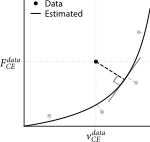

In [6]:
#| label: fig-m-fv
#| fig-cap: |
#|   Graphical illustration of the CE force-velocity parameter estimation using total least squares. For each step-ramp experiment, CE force 
#|   and CE velocity was obtained during the interval in which SEE force changed the least. The nearest point on the CE force-velocity 
#|   relationship was identified based on two criteria: it should satisfy @eq-fvcon, and the line from the datapoint to the CE force-velocity 
#|   relationship should be perpendicular the CE force-velocity relationship. This was done for all step-ramp experiments (other datapoints are 
#|   depicted in grey), while the estimated CE force-velocity relationshp is depicted with the black line.

# %% Imports etc.
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, hillmodel, mp_estimator

# %% Load muscle parameters
mus = 'GMs1'
parFile = os.path.join(dataDir,mus,'parameters',mus+'_OR.pkl')
muspar = pickle.load(open(parFile, 'rb'))

fmax = muspar['fmax']
vmax = muspar['b']/muspar['a']*muspar['fmax']

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=((15.92/3)/2.54+51/600, (15.92/3-0.07)/2.54), constrained_layout=True) # 3:2 ratio
gs = fig.add_gridspec(1,1)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])

# Plot 'data'
ax = axs[0,0]
fcerel = np.linspace(0,1,10000)
q = np.ones_like(fcerel)
lcerel = np.ones_like(fcerel)
fce = fcerel*muspar['fmax']
vce,vcerel = hillmodel.Fce2Vce(fce,q,lcerel,muspar)[0:2]
vcenorm = vce/vmax

# Plot data points
vcenormData = -np.array([0.8, 0.38, 0.11, 0.09])
fcerelData = np.array([0.09, 0.12, 0.37, 0.8])
lcerelData = np.array([1,1,1,1])
qData = hillmodel.ActState(1,lcerelData,muspar)[0]  # [ ] active state
vceModel, fceModel = mp_estimator.helpers.findModelFV(vcenormData*vmax,fcerelData*fmax,lcerelData,qData,muspar)
fcerelModel = fceModel/fmax
vcenormModel = vceModel/vmax

for vd,fd,vm,fm in zip(vcenormData,fcerelData,vcenormModel,fcerelModel):   
    ax.plot(vd,fd,'.',markersize=6,color=[0.75,0.75,0.75])
    ax.plot([vd, vm],[fd, fm],color=[0.75,0.75,0.75],linestyle='--')

vcenormData,fcerelData,lcerelData,fisomrelData,qData = [-0.43, 0.55, 1, 1, 1]
vceModel, fceModel = mp_estimator.helpers.findModelFV(np.array([vcenormData])*vmax,np.array([fcerelData])*fmax,np.array([lcerelData]),np.array([qData]),muspar)
fcerelModel = fceModel[0]/fmax
vcenormModel = vceModel[0]/vmax
p1,*_ = ax.plot(vcenormData,fcerelData,'.',markersize=6,color='k')
ax.plot([vcenormData, vcenormModel],[fcerelData, fcerelModel],linestyle='--',color='k')

# Right angle mark
idx = np.argwhere(np.diff(np.sign(vcenormModel - vcenorm))).flatten()+1
dvdf = np.gradient(fcerel,vcenorm)[idx]
x = np.linspace(vcenorm[idx]-0.125,vcenorm[idx]+0.125,100)
y = dvdf*x
ax.plot(x,y+fcerel[idx]-dvdf*vcenorm[idx],color=[0.5,0.5,0.5],linestyle='-')

a,b = np.polyfit([vcenormData, vcenormModel],[fcerelData, fcerelModel],1)
x = vcenorm
y = x*a+b-0.074

idx = np.argwhere(np.diff(np.sign(fcerel - y))).flatten()
x2 = np.linspace(vcenorm[idx]-0.0507,vcenorm[idx],10000)
y2 = x2*a+b-0.074
ax.plot(x2,y2,color=[0.6,0.6,0.6],linestyle='-')

x3 = x
b3 = x2[0]*a+b-0.074 - (x2[0]*dvdf)
y3 = dvdf*(x3)+b3

idx = np.argwhere(np.diff(np.sign(x*a+b - y3))).flatten()
x4 = np.linspace(x2[0],vcenorm[idx],10000)
y4 = dvdf*(x4)+b3
ax.plot(x4,y4,color=[0.5,0.5,0.5],linestyle='-')

# Check: L1 & L2 should be same length!
L1 = np.sqrt((x2[0]-x2[-1])**2 + (y2[0]-y2[-1])**2)
L2 = np.sqrt((x4[0]-x4[-1])**2 + (y4[0]-y4[-1])**2)

# Plot fce(vce)
l1,*_ = ax.plot(vcenorm,fcerel,'k')

#%% Labels, legend etc.
ax.legend(handles=[p1, l1],  # Only include 'Estimated' and 'Data' in this order
    labels = ['Data', 'Estimated'],
    loc='upper left',
    bbox_to_anchor=(0.02, 1.04),  # shift left (into space between axes) and center vertically
    bbox_transform=ax.transAxes,
    handlelength=1.0,
    handletextpad=0.5,
    labelspacing=0.2,

    alignment='left'
)

# Labels
ax.set_xlim(-1,0)
ax.set_xticks([vcenormData])
ax.set_xticklabels([r'$v_{CE}^{data}$'])
ax.set_ylim(0,1.07)
ax.set_yticks([fcerelData])
ax.set_yticklabels([r'$F_{CE}^{data}$'])

# %% Save and display
plt.show()
fig.savefig('m_fv.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('m_fv.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size:
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("m_fv.svg")
    cust_fig.report_fig_size("m_fv.pdf")  

## Results

### Figure 6

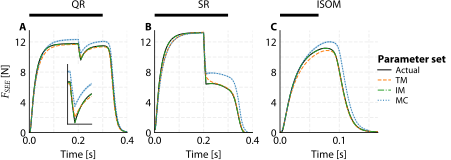

In [7]:
#| label: fig-r-protocols
#| fig-cap: |
#|   Representative example of SEE force over time during a quick-release (A), step-ramp (B) and isometric experiment (C). The inset in (A) 
#|   depicts the SEE force over time around the quick-release. The SEE force over time is depicted for four sets of parameter values: 1) the actual 
#|   values (i.e., literature-obtained; black solid line), those obtained with the traditional method (TM; orange dashed line), those obtained 
#|   with the improved method (IM; green dashed-dotted line) and those resulting from the Monte Carlo Simulations (MC; blue dotted line, with 
#|   shaded 95% confidence interval).

# %% Imports
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, helpers

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

#fig = plt.figure(figsize=(15.92/2.54+64/600, (15.92/3+0.57)/2.54), constrained_layout=True)
fig = plt.figure(figsize=(15.92/2.54+64/600, (15.92/3+0.57)/2.54), constrained_layout=True)
gs = fig.add_gridspec(2, 3, height_ratios=[1, 36])
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])
ax_inset = fig.add_axes([0.15, 0.2, 0.15, 0.2])

colorSet = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorSet[3] = colorSet[0]
colorSet[0] = '#000000'
colors = colorSet
linestyles = ['-', '--', '-.', ':']

# %% Datafile info
mus = 'GMs1'
iFile = [5,3,5]
protocol = ['QR','SR','ISOM']

# %% Plot STIM
for iExp,exp in enumerate(['QR','SR','ISOM']):
    dataDirExp = os.path.join(dataDir,mus,'dataExp',exp,'')
    files = sorted(glob.glob(dataDirExp+mus+r'*.csv'))
    iSel = iFile[iExp]
    filepath = files[iSel]
    data = pd.read_csv(filepath).T.to_numpy()
    time, lmtc, stim, fsee = data[0:4]
    
    _,tStimOn,tStimOff = helpers.get_stim(time,stim)
    
    verts = [
       (tStimOn[0], 0.99),  # left, bottom
       (tStimOn[0], 1.01),  # left, top
       (tStimOff[0], 1.01),  # right, top
       (tStimOff[0], 0.99),  # right, bottom
    ]

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
    ]

    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='k', lw=0)
    
    ax = axs[0, iExp]  # top row for STIM
    ax.add_patch(patch)
    ax.set_axis_off()
    ax.autoscale(enable=True, axis='y', tight=True)

# %% Plot SEE Force
lineSet = []
for iExp,exp in enumerate(['QR','SR','ISOM']):
    iSel = iFile[iExp] # fileNo. to be plotted.
    for iPar,vPar in enumerate(['OR','TM','IM','MC']):
        ax = axs[1, iExp]  # top row for STIM
        if vPar != 'MC':
            if vPar == 'OR':
                dataDirExp = os.path.join(dataDir,mus,'dataExp',exp,'')
            else:
                dataDirExp = os.path.join(dataDir,mus,'simsExp',vPar,exp,'') 
            files = sorted(glob.glob(dataDirExp+mus+r'*.csv'))
            filepath = files[iSel]
            data = pd.read_csv(filepath).T.to_numpy()
            time, lmtc, stim, fsee = data[0:4]
            
            l, = ax.plot(time,fsee,color=colors[iPar],linestyle=linestyles[iPar])
            lineSet.append(l)
            if exp == 'QR':
                ax_inset.plot(time,fsee,color=colors[iPar],linestyle=linestyles[iPar])
        elif vPar == 'MC':
            if exp == 'QR':
                n = 1000
            elif exp == 'SR':
                n = 1000
            elif exp == 'ISOM':
                n = 500
            
            fseeStack = np.empty((0,n))
            for iMC in range(1,51):
                dataDirExp = os.path.join(dataDir,mus,'simsMC',exp,f'{iMC:02d}','')

                subfldr = vPar+'{:02d}'.format(iMC)
                fileName = mus+'_'+exp+f'{iSel:02d}'+'_'+subfldr+'.csv'
                data = pd.read_csv(dataDirExp+fileName).T.to_numpy()
                
                time, lmtc, stim, fsee = data[0:4]
                fseeStack = np.vstack((fseeStack,fsee[0:n]))
            m = np.mean(fseeStack,0)
            s = np.std(fseeStack,0)
            
            ci = 1.96 * s/np.sqrt(50)
            mi = m-ci
            mx = m+ci
            # axs[iAx].fill_between(time, (m-ci), (m+ci), color='b', alpha=.1)
            l, = ax.plot(time[0:n],m,color=colors[iPar],linestyle=linestyles[iPar])
            ax.fill_between(time[0:n], (mi), (mx), color=colors[iPar], alpha=.25)
            lineSet.append(l)
            
            if exp == 'QR':
                ax_inset.fill_between(time[0:n], (mi), (mx), color=colors[iPar], alpha=.25)
                ax_inset.plot(time[0:n],m,color=colors[iPar],linestyle=linestyles[iPar])
                
# %% Labels & Titles etc.
lineSet = lineSet[0:4]
legend_labels = ['Actual', 'TM', 'IM', 'MC']
for line, label in zip(lineSet, legend_labels):
    line.set_label(label)

fig.legend(handles=lineSet,
           title=r"Parameter set",
           title_fontproperties={'weight':'bold'},
           loc='outside right',
           # bbox_to_anchor=(1, .5),
           frameon=False,
           handlelength=1.45,
           handletextpad=0.5,
           labelspacing=0.2,
           alignment='left'
           )

axs[0,0].set_title('QR')
axs[0,1].set_title('SR')
axs[0,2].set_title('ISOM')

axs[1,0].set_xlabel('Time [s]')
axs[1,1].set_xlabel('Time [s]')
axs[1,2].set_xlabel('Time [s]')
axs[1,0].set_ylabel('$F_{SEE}$'+' [N]')

axs[0,0].set_xlim(0.1,0.5)
axs[1,0].set_xlim(0.1,0.5)
axs[1,0].set_xticks([0.1,0.3,0.5])
axs[1,0].set_xticklabels(['0.0','0.2','0.4'])
axs[1,0].set_xticks([0.2,0.4], minor=True)
axs[1,0].set_ylim(0,13.5)
axs[1,0].set_yticks([0,4,8,12])
axs[1,0].set_yticks([2,6,10], minor=True)

axs[0,1].set_xlim(0.1,0.5)
axs[1,1].set_xlim(0.1,0.5)
axs[1,1].set_xticks([0.1,0.3,0.5])
axs[1,1].set_xticklabels(['0.0','0.2','0.4'])
axs[1,1].set_xticks([0.2,0.4], minor=True)
axs[1,1].set_ylim(0,13.5)
axs[1,1].set_yticks([0,4,8,12])
axs[1,1].set_yticks([2,6,10], minor=True)

axs[0,2].set_xlim(0.1,0.265)
axs[1,2].set_xlim(0.1,0.265)

axs[1,2].set_xticks([0.1,0.2])
axs[1,2].set_xticklabels(['0.0','0.1'])
axs[1,2].set_xticks([0.15,0.25], minor=True)
axs[1,2].set_ylim(0,13.5)
axs[1,2].set_yticks([0,4,8,12])
axs[1,2].set_yticks([2,6,10], minor=True)

fig.canvas.draw()
ax_inset.set_xlim(0.295,0.345)
ax_inset.set_ylim(9.5,12.7)
ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])
ax_inset.grid(False)
pos = [axs[1,0].get_position().x0+0.08, axs[1,0].get_position().y0+0.05, axs[1,0].get_position().width-0.16, axs[1,0].get_position().height-0.3]
ax_inset.set_position(pos)

cust_fig.add_labels(fig,axs[1,:],['A','B','C'])

# %% Save and display 
plt.show()     
fig.savefig('r_protocols.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('r_protocols.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size:
    cust_fig.report_axes_size(fig,axs.flatten()) 
    cust_fig.report_fig_size("r_protocols.svg") 
    cust_fig.report_fig_size("r_protocols.pdf") 

### Figure 7

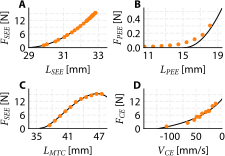

In [8]:
#| label: fig-r-insitu-fit
#| fig-cap: |
#|   Representative example of experimental *in situ* data of rat 1 for the SEE force-length relationship (A), PEE force-length relationship (B), 
#|   MTC force-length relationship (C) and the CE force-velocity relationship (D).** The orange dots depicts the experimental *in situ* data and the 
#|   solid black line depicts the model fit.

# %% Imports
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, hillmodel

# %% Load muscle parameters
mus = 'GMe1'
parFile = os.path.join(dataDir,mus,'parameters',mus+'_IM.pkl')
muspar, dataQRout, dataSRout, dataACTout = pickle.load(open(parFile, 'rb'))

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=((15.92/2)/2.54+50/600, (15.92/3+0.43)/2.54), constrained_layout=True) # 3:1 ratio
gs = fig.add_gridspec(2,2)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])

colorSet = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorSet[3] = colorSet[0]
colorSet[0] = '#000000'
colors = colorSet

# %% Panel A: Fsee(Lsee)
ax = axs[0,0]
lseeQRpre = dataQRout['lseeQRpre']
lseeQRpst = dataQRout['lseeQRpst']
fseeQRpre = dataQRout['fseeQRpre']
fseeQRpst = dataQRout['fseeQRpst']
lpeeQR = dataQRout['lpeeQR']
fpeeQR = dataQRout['fpeeQR']
lmtcQRpre = dataQRout['lmtcQRpre']

lsee = np.linspace(muspar['lsee0'],muspar['lsee0']+(muspar['fmax']/muspar['ksee'])**0.5,100)
fsee = hillmodel.LEE2Force(lsee,0,muspar)[0]
ax.plot(lsee,fsee,'k',)
ax.plot(lseeQRpre,fseeQRpre,'.',color=colorSet[1])
ax.plot(lseeQRpst,fseeQRpst,'.',color=colorSet[1])

ax.set_xlabel('$L_{SEE}$'+' [mm]')
ax.set_ylabel('$F_{SEE}$'+' [N]')
ax.set_xlim(0.029,0.0335)
ax.set_xticks([0.029,0.030,0.031,0.032,0.033])
ax.set_xticklabels(['29','','31','','33'])
ax.set_ylim(0,17.5)
ax.set_yticks([0,3,6,9,12,15])
ax.set_yticklabels(['0','','6','','12',''])

# %% Panel B: Fpee(Lpee)
ax = axs[0,1]
lpee = np.linspace(muspar['lpee0'],muspar['lpee0']+(muspar['fmax']/muspar['kpee'])**0.5,100)
fpee = hillmodel.LEE2Force(0,lpee,muspar)[1]
ax.plot(lpee,fpee,'k') 
ax.plot(lpeeQR,fpeeQR,'.',color=colorSet[1])

ax.set_xlabel('$L_{PEE}$'+' [mm]')
ax.set_ylabel('$F_{PEE}$'+' [N]')
ax.set_xlim(0.0105,0.0195)
ax.set_xticks([0.011,0.013,0.015,0.017,0.019])
ax.set_xticklabels(['11','','15','','19'])
ax.set_ylim(0,0.55)
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.set_yticklabels(['0.0','','0.2','','0.4',''])

# Panel C: Fsee(Lmtc)
ax = axs[1,0]
lmtc = np.linspace((1-muspar['w'])*muspar['lce_opt']+muspar['lsee0'],(1+muspar['w'])*muspar['lce_opt']+muspar['lsee0'],100)
fsee = hillmodel.ForceEQ(lmtc,1,muspar)[0]
ax.plot(lmtc,fsee,'k') 
ax.plot(lmtcQRpre,fseeQRpre,'.',color=colorSet[1])

ax.set_xlabel('$L_{MTC}$'+' [mm]')
ax.set_ylabel('$F_{SEE}$'+' [N]')
ax.set_xlim(0.0335,0.0485)
ax.set_xticks([0.035,0.038,0.041,0.044,0.047])
ax.set_xticklabels(['35','','41','','47'])
ax.set_ylim(0,17.5)
ax.set_yticks([0,3,6,9,12,15])
ax.set_yticklabels(['0','','6','','12',''])

# Panel D: fce(vce)
ax = axs[1,1]
vceSR = dataSRout['vceSR']
fceSR = dataSRout['fceSR']
lcerelSR = dataSRout['lcerelSR']
fce = np.linspace(0,1,100)*muspar['fmax']
lcerelSR_mean = np.ones_like(fce)*lcerelSR.mean()
q = hillmodel.ActState(1,lcerelSR_mean,muspar)[0]
vce = hillmodel.Fce2Vce(fce,q,lcerelSR_mean,muspar)[0]
ax.plot(vce,fce,'k') 
ax.plot(vceSR,fceSR,'.',color=colorSet[1])

ax.set_xlabel('$V_{CE}$'+' [mm/s]')
ax.set_ylabel('$F_{CE}$'+' [N]')
ax.set_xlim(-0.15,0)
ax.set_xticks([-0.125,-0.10,-0.075,-0.05,-0.025,0])
ax.set_xticklabels(['','-100','','50','','0'])
ax.set_ylim(0,17.5)
ax.set_yticks([0,3,6,9,12,15])
ax.set_yticklabels(['0','','6','','12',''])

# %% Labels & Titles
cust_fig.add_labels(fig,axs.flatten(),['A','B','C','D'])

# Save and display 
plt.show()
fig.savefig('r_insitu_fit.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('r_insitu_fit.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size:
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("r_insitu_fit.svg") 
    cust_fig.report_fig_size("r_insitu_fit.pdf") 

### Figure 8

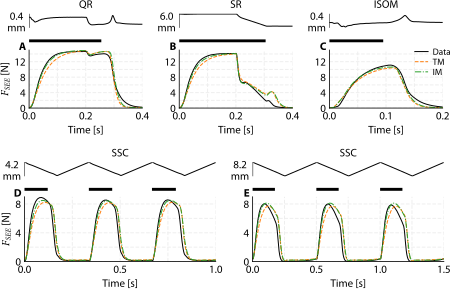

In [9]:
#| eval: false
#| echo: false
#| output: true
#| label: fig-r-ssc-exp
#| fig-cap: |
#|   Representative example of experimental *in situ* data and simulation results of rat 1 for SEE force over time during a quick-release 
#|   experiment (A), step-ramp experiment (B), isometric experiment (C) and two stretch-shortening cycles (D & E). The simulation results were 
#|   obtained by re-simulating the experimental protocol with the MTC length and CE stimulation from the experimental data as input and by using 
#|   either the parameter set obtained with the traditional method (TM; orange dashed line) or the improved method (IM; green dash-dotted line). 
#|   For each panel, the top plot represents MTC length over time, with the bar indicating its range in mm. CE stimulation is maximal during the 
#|   periods indicated by the black bars and is ‘off’ elsewhere.

# %% Imports
import os, glob, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.path import Path
plt.close('all')

# Paths
cwd = os.getcwd()
baseDir = os.path.join(cwd,'..')
dataDir = os.path.join(baseDir,'data')
funcDir = os.path.join(baseDir,'analysis','functions')
sys.path.append(funcDir)

# Custom imports
import cust_fig, helpers

# %% Load muscle parameters
mus = 'GMe1'
dataDirExp = os.path.join(dataDir,mus,'dataExp','')
dataDirTrm = os.path.join(dataDir,mus,'simsExp','TM','')
dataDirImp = os.path.join(dataDir,mus,'simsExp','IM','')

# %% Figure setup
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=(15.92/2.54+51/600, (15.92/1.5-0.18)/2.54), constrained_layout=True) # 3:2 ratio  
# fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0.05, wspace=0)
gs = fig.add_gridspec(3,1,height_ratios=[1.0,0.05,1.035])
gs0 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0],height_ratios=[0.97,1/5.0,4])
gs1 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[2],height_ratios=[0.86,1/5.5,4])
axs_top = np.array([[fig.add_subplot(gs0[i, j]) for j in range(gs0.ncols)] for i in range(gs0.nrows)])
axs_bot = np.array([[fig.add_subplot(gs1[i, j]) for j in range(gs1.ncols)] for i in range(gs1.nrows)])

colorSet = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorSet[3] = colorSet[0]
colorSet[0] = '#000000'
colors = colorSet
linestyles = ['-', '--','-.']

# %% QR, SR & ISOM
iFileQR, iFileSR, iFileISOM = 4, 7, 4
expFiles = [sorted(glob.glob(dataDirExp+'QR/*.csv'))[iFileQR], 
            sorted(glob.glob(dataDirExp+'SR/*.csv'))[iFileSR], 
            sorted(glob.glob(dataDirExp+'ISOM/*.csv'))[iFileISOM]]
trmFiles = [sorted(glob.glob(dataDirTrm+'QR/*.csv'))[iFileQR],
            sorted(glob.glob(dataDirTrm+'SR/*.csv'))[iFileSR], 
            sorted(glob.glob(dataDirTrm+'ISOM/*.csv'))[iFileISOM]]
impFiles = [sorted(glob.glob(dataDirImp+'QR/*.csv'))[iFileQR], 
            sorted(glob.glob(dataDirImp+'SR/*.csv'))[iFileSR], 
            sorted(glob.glob(dataDirImp+'ISOM/*.csv'))[iFileISOM]]
expNames = ['QR', 'SR', 'ISOM']

for iFile,(expFilepath,trmFilepath,impFilepath,exp) in enumerate(zip(expFiles,trmFiles,impFiles,expNames)):
    expFilename = expFilepath.rsplit('/', 1)[-1][:-4]
    trmFilename = trmFilepath.rsplit('/', 1)[-1][:-4]
    impFilename = impFilepath.rsplit('/', 1)[-1][:-4]

    if expFilename[:-3] != trmFilename[:-3] or expFilename[:-3] != impFilename[:-3]:
        # if filesnames are not the same then we have a problem, check what it is!
        breakpoint()
    
    # First treat experimental data
    dataExp = pd.read_csv(expFilepath).T.to_numpy()
    timeExp,lmtcExp,stimExp,fseeExp = dataExp[0:4]    
    dataTrm = pd.read_csv(trmFilepath).T.to_numpy()
    timeTrm,lmtcTrm,stimTrm,fseeTrm = dataTrm[0:4] 
    dataImp = pd.read_csv(impFilepath).T.to_numpy()
    timeImp,lmtcImp,stimImp,fseeImp = dataImp[0:4]
    _, tStimOn, tStimOff = helpers.get_stim(timeExp,stimExp)
    
    if sum(timeExp==timeTrm) != len(dataExp.T) or sum(lmtcExp==lmtcTrm) != len(dataExp.T):
        # if the experimental data and simulated data are not the same, the we have a problem!
        breakpoint()
    if sum(timeExp==timeImp) != len(dataExp.T) or sum(lmtcExp==lmtcImp) != len(dataExp.T):
        # if the experimental data and simulated data are not the same, the we have a problem!
        breakpoint()
        
    iStart = np.argmin(abs(timeExp-tStimOn[0]))
    iStop = np.argmin(abs(timeExp-tStimOff[-1]-0.2)) # 0.1s after tStimOff
    
    timeExp = timeExp[iStart:iStop]-timeExp[iStart]
    lmtcExp = lmtcExp[iStart:iStop]
    fseeExp = fseeExp[iStart:iStop]
    stimMdl = stimTrm[iStart:iStop]
    fseeTrm = fseeTrm[iStart:iStop]
    fseeImp = fseeImp[iStart:iStop]
    tStimOff = tStimOff-tStimOn[0]
    tStimOn = tStimOn-tStimOn[0]
     
    # Lmtc(t)
    ax = axs_top[0,iFile]
    ax.plot(timeExp,lmtcExp,'k')
    
    # Plot STIM(t)
    ax = axs_top[1,iFile]
    for tOn,tOff in zip(tStimOn,tStimOff):
        verts = [
           (tOn, 0.99),  # left, bottom
           (tOn, 1.01),  # left, top
           (tOff, 1.01),  # right, top
           (tOff, 0.99),  # right, bottom
        ]
    
        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
        ]
    
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='k', lw=0)
        ax.add_patch(patch)
    
    # Fsee(t)
    ax = axs_top[2,iFile]
    ax.plot(timeExp,fseeExp,colors[0],linestyle=linestyles[0])
    ax.plot(timeExp,fseeTrm,colors[1],linestyle=linestyles[1])
    ax.plot(timeExp,fseeImp,colors[2],linestyle=linestyles[2])

# %% SSC    
iFileOne, iFileTwo = 5, 32
expFiles = [sorted(glob.glob(dataDirExp+'SSC/*.csv'))[iFileOne], 
            sorted(glob.glob(dataDirExp+'SSC/*.csv'))[iFileTwo]]
trmFiles = [sorted(glob.glob(dataDirTrm+'SSC/*.csv'))[iFileOne], 
            sorted(glob.glob(dataDirTrm+'SSC/*.csv'))[iFileTwo]]
impFiles = [sorted(glob.glob(dataDirImp+'SSC/*.csv'))[iFileOne], 
            sorted(glob.glob(dataDirImp+'SSC/*.csv'))[iFileTwo]]

for iFile,(expFilepath,trmFilepath,impFilepath) in enumerate(zip(expFiles,trmFiles,impFiles)):
    expFilename = expFilepath.rsplit('/', 1)[-1][:-4]
    trmFilename = trmFilepath.rsplit('/', 1)[-1][:-4]
    impFilename = impFilepath.rsplit('/', 1)[-1][:-4]
    
    if expFilename[:-3] != trmFilename[:-3] or expFilename[:-3] != impFilename[:-3]:
        # if filesnames are not the same then we have a problem, check what it is!
        breakpoint()
    
    # First treat experimental data
    dataExp = pd.read_csv(expFilepath).T.to_numpy()
    timeExp,lmtcExp,stimExp,fseeExp = dataExp[0:4]    
    dataUnc = pd.read_csv(trmFilepath).T.to_numpy()
    timeTrm,lmtcTrm,stimTrm,fseeTrm = dataUnc[0:4] 
    dataImp = pd.read_csv(impFilepath).T.to_numpy()
    timeImp,lmtcImp,stimImp,fseeImp = dataImp[0:4]
    _, tStimOn, tStimOff = helpers.get_stim(timeExp,stimExp)
    
    if sum(timeExp==timeTrm) != len(dataExp.T) or sum(lmtcExp==lmtcTrm) != len(dataExp.T):
        # if the experimental data and simulated data are not the same, the we have a problem!
        breakpoint()
    if sum(timeExp==timeImp) != len(dataExp.T) or sum(lmtcExp==lmtcImp) != len(dataExp.T):
        # if the experimental data and simulated data are not the same, the we have a problem!
        breakpoint()
        
    iStart = np.argmin(abs(timeExp-tStimOn[0]))
    iStop = np.argmin(abs(timeExp-tStimOff[-1]-0.5)) # 0.5s after tStimOff
    
    timeExp = timeExp[iStart:iStop]-timeExp[iStart]
    lmtcExp = lmtcExp[iStart:iStop]
    fseeExp = fseeExp[iStart:iStop]
    stimMdl = stimTrm[iStart:iStop]
    fseeTrm = fseeTrm[iStart:iStop]
    fseeImp = fseeImp[iStart:iStop]
    tStimOff = tStimOff-tStimOn[0]
    tStimOn = tStimOn-tStimOn[0]
    
    if iFile == 0:
        iAx = 9
    else:
        iAx = 10
    
    # Plot lmtc(t)
    ax = axs_bot[0,iFile]
    ax.plot(timeExp,lmtcExp,'k')
    
    # Plot STIM(t)
    ax = axs_bot[1,iFile]
    for tOn,tOff in zip(tStimOn,tStimOff):
        verts = [
           (tOn, 0.99),  # left, bottom
           (tOn, 1.01),  # left, top
           (tOff, 1.01),  # right, top
           (tOff, 0.99),  # right, bottom
        ]
    
        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
        ]
    
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='k', lw=0)
        ax.add_patch(patch)
    
    # Fsee(t)
    ax = axs_bot[2,iFile]
    ax.plot(timeExp,fseeExp,colors[0],linestyle=linestyles[0])
    ax.plot(timeExp,fseeTrm,colors[1],linestyle=linestyles[1])
    ax.plot(timeExp,fseeImp,colors[2],linestyle=linestyles[2])

# %% Label, titles & legend
axs_top[2,2].legend(['Data', 'TM', 'IM'],
    loc='upper right',
    bbox_to_anchor=(1.11, 1.11),  # shift left (into space between axes) and center vertically
    bbox_transform=axs_top[2,2].transAxes,
    handlelength=1.45,
    handletextpad=0.5,
    labelspacing=0.2,
    alignment='left'
)


axs = np.concatenate([axs_top.flatten(),axs_bot.flatten()])
for iAx in [0,1,2,3,4,5,9,10,11,12]: # STIM & LMTC subplots
    ax = axs[iAx]
    
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
for iAx in [3,4,5,11,12]:
    ax = axs[iAx]
    ax.autoscale(enable=True, axis='y', tight=True)

# QR
ax = axs_top[0,0] # MTC subplots
ax.set_xlim(0,0.4)
ax.set_ylim(45.2e-3,45.6e-3) # 0.4 mm range
y_min, y_max = 45.2e-3, 45.6e-3
y_range = (y_max-y_min)*1e3
ax.plot([0, 0], [y_min, y_max], color='black', lw=1)
ax.set_yticks([(y_min+y_max)/2])
ax.set_yticklabels([f'{y_range:.1f} \n mm'])
ax.tick_params(axis='y', size=0)
ax.grid(False)

ax = axs_top[1,0] # STIM subplots
ax.set_xlim(0,0.4)
  
ax = axs_top[2,0] # Fsee subplots
ax.set_xlim(0,0.4)
ax.set_xticks([0,0.2,0.4])
ax.set_xticks([0.1,0.3], minor=True)
ax.set_ylim(0,15)
ax.set_yticks([0,4,8,12])
ax.set_yticks([2,6,10,14], minor=True)

# SR
ax = axs_top[0,1] # MTC subplots
ax.set_xlim(0,0.4)
ax.set_ylim(38.6e-3,44.6e-3) # 6 mm range
y_min, y_max = 38.6e-3, 44.6e-3
y_range = (y_max-y_min)*1e3
ax.plot([0, 0], [y_min, y_max], color='black', lw=1)
ax.set_yticks([(y_min+y_max)/2])
ax.set_yticklabels([f'{y_range:.1f} \n mm'])
ax.tick_params(axis='y', size=0)
ax.grid(False)

ax = axs_top[1,1] # STIM subplots
ax.set_xlim(0,0.4)
  
ax = axs_top[2,1] # Fsee subplots
ax.set_xlim(0,0.4)
ax.set_xticks([0,0.2,0.4])
ax.set_xticks([0.1,0.3], minor=True)
ax.set_ylim(0,15)
ax.set_yticks([0,4,8,12])
ax.set_yticks([2,6,10,14], minor=True)

# ISOM
ax = axs_top[0,2] # MTC subplots
ax.set_xlim(0,0.2)
ax.set_ylim(42.35e-3,42.75e-3) # 0.4 mm range
y_min, y_max = 42.35e-3, 42.75e-3
y_range = (y_max-y_min)*1e3
ax.plot([0, 0], [y_min, y_max], color='black', lw=1)
ax.set_yticks([(y_min+y_max)/2])
ax.set_yticklabels([f'{y_range:.1f} \n mm'])
ax.tick_params(axis='y', size=0)
ax.grid(False)

ax = axs_top[1,2] # STIM subplots
ax.set_xlim(0,0.2)
  
ax = axs_top[2,2] # Fsee subplots
ax.set_xlim(0,0.2)
ax.set_xticks([0,0.1,0.2])
ax.set_xticks([0.05,0.15], minor=True)
ax.set_ylim(0,15)
ax.set_yticks([0,4,8,12])
ax.set_yticks([2,6,10,14], minor=True)

# SSC w/ 4 mm length excursion
ax = axs_bot[0,0] # MTC subplots
ax.set_xlim(0,1)
ax.set_ylim(41.3e-3,45.5e-3) # 4.2 mm range
y_min, y_max = 41.3e-3, 45.5e-3
y_range = (y_max-y_min)*1e3
ax.plot([0, 0], [y_min, y_max], color='black', lw=1)
ax.set_yticks([(y_min+y_max)/2])
ax.set_yticklabels([f'{y_range:.1f} \n mm'])
ax.tick_params(axis='y', size=0)
ax.grid(False)

ax = axs_bot[1,0] # STIM subplots
ax.set_xlim(0,1)
  
ax = axs_bot[2,0] # Fsee subplots
ax.set_xlim(0,1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticks([0.25,0.75], minor=True)
ax.set_ylim(0,9)
ax.set_yticks([0,4,8])
ax.set_yticks([2,6], minor=True)

# SSC w/ 8 mm length excursion
ax = axs_bot[0,1] # MTC subplots
ax.set_xlim(0,1.5)
ax.set_ylim(39.3e-3,47.5e-3) # 8.2 mm range
y_min, y_max = 39.3e-3, 47.5e-3
y_range = (y_max-y_min)*1e3
ax.plot([0, 0], [y_min, y_max], color='black', lw=1)
ax.set_yticks([(y_min+y_max)/2])
ax.set_yticklabels([f'{y_range:.1f} \n mm'])
ax.tick_params(axis='y', size=0)
ax.grid(False)

ax = axs_bot[1,1] # STIM subplots
ax.set_xlim(0,1.5)
  
ax = axs_bot[2,1] # Fsee subplots
ax.set_xlim(0,1.5)
ax.set_xticks([0,0.5,1.0,1.5])
ax.set_xticks([0.25,0.75,1.25], minor=True)
ax.set_ylim(0,9)
ax.set_yticks([0,4,8])
ax.set_yticks([2,6], minor=True)

axs_top[2,0].set_ylabel('$F_{SEE}$' + ' [N]')
axs_top[2,0].set_xlabel('Time [s]')
axs_top[2,1].set_xlabel('Time [s]')
axs_top[2,2].set_xlabel('Time [s]')
axs_bot[2,0].set_ylabel('$F_{SEE}$' + ' [N]')
axs_bot[2,0].set_xlabel('Time [s]')
axs_bot[2,1].set_xlabel('Time [s]')

axs_top[0,0].set_title('QR')
axs_top[0,1].set_title('SR')
axs_top[0,2].set_title('ISOM')
axs_bot[0,0].set_title('SSC')
axs_bot[0,1].set_title('SSC')

axs_labels = np.concatenate([axs_top[2,:], axs_bot[2,:]])
cust_fig.add_labels(fig,axs_labels,['A','B','C','D','E'],location='fig')
    
# %%  Save and display 
plt.show()
fig.savefig('r_ssc_exp.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('r_ssc_exp.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size:
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("r_ssc_exp.svg") 
    cust_fig.report_fig_size("r_ssc_exp.pdf") 


## Supplementary material
### Figure S1

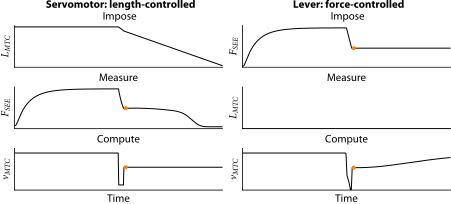

In [10]:
#| label: suppfig-servo-vs-lever
#| fig-cap: Comparison between a length-controlled step-ramp experiment and a force-controlled
#|   quick-release experiment. In length-controlled step-ramp experiment (left), MTC length over time is
#|   imposed using a servomotor, while SEE force is measured. MTC velocity is computed at the time instance
#|   at which SEE force is near constant. In the force-controlled quick-release experiment (right), SEE force
#|   over time is imposed via a lever, while MTC length is measured. MTC velocity is computed at the time
#|   instance where MTC velocity is maximal after the change in SEE force. Both methods yield one datapoint
#|   (depicted with the orange dot) of the force-velocity relationship.

# %% Imports
import glob, os, sys, pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import integrate
plt.close('all')

# Set directories
cwd = Path.cwd()
baseDir = cwd.parent
dataDir = baseDir / 'data'
funcDir = baseDir / 'analysis' / 'functions'
sys.path.append(str(funcDir))

# Custom imports
import cust_fig, hillmodel, isotonic

#%%
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=(15.92/2.54+51/600, (15.92/2-0.54)/2.54), constrained_layout=True) # 2:3 ratio (1254px x 1880px)
gs = fig.add_gridspec(3,2)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(gs.ncols)] for i in range(gs.nrows)])

colorSet = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorSet[3] = colorSet[0]
colorSet[0] = '#000000'

#%% Load muscle parameter values
mus = 'GMs1'
parFile = os.path.join(dataDir,mus,'parameters',mus+'_OR.pkl')
muspar = pickle.load(open(parFile, 'rb'))

#%% First plot of servomotor
exp = 'SR'
vPar = 'OR'
dataDirExp = os.path.join(dataDir,mus,'dataExp',exp,'')

files = sorted(glob.glob(dataDirExp+r'*')) 
filepath = files[3]
data = pd.read_csv(filepath).T.to_numpy()
time, lmtc, stim, fsee = data[0:4,200:]
time = time-time[0]
vmtc = np.gradient(lmtc,time)            

axs[0,0].plot(time,lmtc,color=colorSet[0])
axs[1,0].plot(time,fsee,color=colorSet[0])
axs[1,0].plot(time[428],fsee[428],'.',color=colorSet[1])
axs[2,0].plot(time,vmtc,color=colorSet[0])
axs[2,0].plot(time[428],vmtc[428],'.',color=colorSet[1])

#%% Then of lever system
lmtc0 = lmtc[0] # start with same length at t=0

inputs = {}
inputs['tIso'] = 0.2
inputs['lmtc0'] = lmtc0
inputs['fseeDrop'] = 6.4
inputs['shorteningDistance'] = -np.nan # never stop isotnic mode..

#
tspan   = [0, 0.4]
gamma0  = muspar['gamma_0']
lcerel0 = hillmodel.ForceEQ(lmtc0,gamma0,muspar)[1]
state0  = [gamma0, lcerel0, 0]
fun     = lambda t, x: isotonic.SimuIso(t,x,inputs,muspar)[0]
event   = lambda t, x: isotonic.endSimu(t,x,inputs,muspar)
event.terminal = False
sol     = integrate.solve_ivp(fun,tspan,state0,method='Radau',rtol=1e-6,dense_output=True,events=event)

# Post-proceess
time = np.arange(*[0, sol.t[-1]], 1e-3)
state = sol.sol(time)
statedot, y = isotonic.SimuIso(time,state,inputs,muspar)

# Unravel
gamma = state[0]
lcerel = state[1]
H = state[2]

gammad = statedot[0]
vcerel = statedot[1]
Hdot = statedot[2]

lmtc = y[0]
stim = y[1]
fsee = y[2]
vmtc = np.gradient(lmtc,time)

axs[0,1].plot(time,fsee,color=colorSet[0])
axs[0,1].plot(time[214],fsee[214],'.',color=colorSet[1])
axs[1,1].plot(time,lmtc,color=colorSet[0])
axs[2,1].plot(time,vmtc,color=colorSet[0])
axs[2,1].plot(time[214],vmtc[214],'.',color=colorSet[1])

#%% Axis etc.
for ax in axs.flatten():
    ax.set_xlim(0,0.4)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in [axs[0,0], axs[2,0]]: # lmtc
    ax.set_ylim(37e-3,44e-3)
for ax in [axs[0,1], axs[1,1]]: # fsee
    ax.set_ylim(0,14)
for ax in [axs[2,0], axs[2,1]]: # vmtc
    ax.set_ylim(-0.08,1e-2) 

axs[0,0].set_title('' + '\n Impose')
axs[0,0].set_ylabel('$L_{MTC}$')
axs[0,1].set_title('' + '\n Impose')
axs[0,1].set_ylabel('$F_{SEE}$')
axs[1,0].set_title('Measure')
axs[1,0].set_ylabel('$F_{SEE}$')
axs[1,1].set_title('Measure')
axs[1,1].set_ylabel('$L_{MTC}$')
axs[2,0].set_title('Compute')
axs[2,0].set_ylabel('$v_{MTC}$')
axs[2,1].set_title('Compute')
axs[2,1].set_ylabel('$v_{MTC}$')

axs[2,0].set_xlabel('Time')
axs[2,1].set_xlabel('Time')

# axs[0,0].set_title('Servomotor: length-controlled' + '\n Impose', fontweight='bold')
# axs[0,1].set_title('Lever: force-controlled' + '\n Impose', fontweight='bold')
fig.text(0.27, 0.95, 'Servomotor: length-controlled', ha='center', fontweight='bold')
fig.text(0.77, 0.95, 'Lever: force-controlled', ha='center', fontweight='bold')

# %% Save
fig.align_labels() 
plt.show()
fig.savefig('s_servo_vs_lever.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('s_servo_vs_lever.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_axes_size(fig,axs.flatten())
    cust_fig.report_fig_size("s_servo_vs_lever.svg") 
    cust_fig.report_fig_size("s_servo_vs_lever.pdf") 

### Figure S2

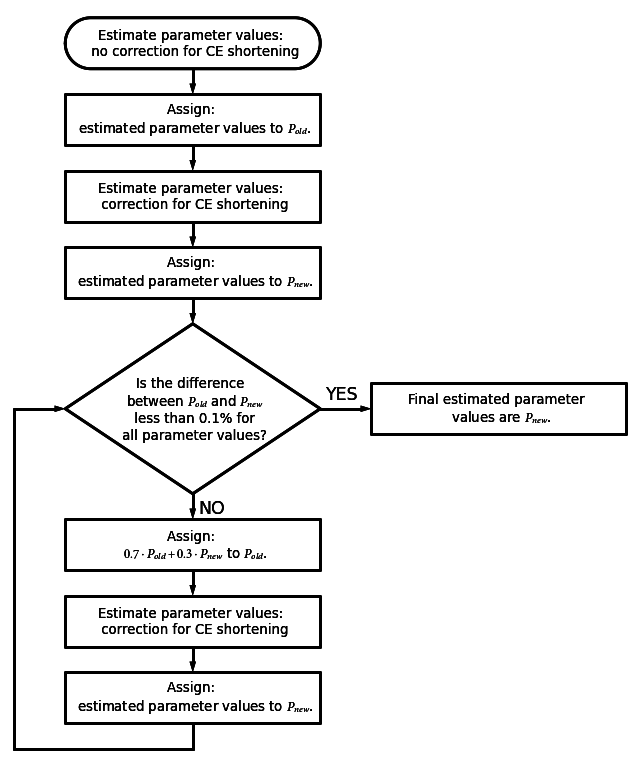

In [11]:
#| label: suppfig-flowchart
#| fig-cap: Flowchart of the improved method. Using the improved method, parameter values were
#|   estimated until the change in all parameter values was less than 0.1%.

import sys
import matplotlib.pyplot as plt
import schemdraw
from pathlib import Path
from schemdraw import flow
plt.close('all')

# Set directories
cwd = Path.cwd()
baseDir = cwd.parent
dataDir = baseDir / 'data'
funcDir = baseDir / 'analysis' / 'functions'
sys.path.append(str(funcDir))

# Custom import
import cust_fig

#%%
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

width = 6
height = 1.2

# IMPORTANT: no context manager
d = schemdraw.Drawing()
d.config(fontsize=11)

# Box 1: Start block
start = flow.Start(w=width, h=height).label(
    'Estimate parameter values: \n no correction for CE shortening')
d += start
d += flow.Arrow().down(d.unit/5)

# Box 2: P_old assignment
pold = flow.Box(w=width, h=height).label(
    'Assign: \n estimated parameter values to $P_{old}$.')
d += pold
d += flow.Arrow().down(d.unit/5)

# --- Box 3: Correction block
correction1 = flow.Box(w=width, h=height).label(
    'Estimate parameter values: \n correction for CE shortening')
d += correction1
d += flow.Arrow().down(d.unit/5)

# Box 4: P_new assignment
pnew1 = flow.Box(w=width, h=height).label(
    'Assign: \n estimated parameter values to $P_{new}$.')
d += pnew1
d += flow.Arrow().down(d.unit/5)

# Box: Decision
decision = flow.Decision(
    w=width, h=width/1.5, E='YES', S='NO'
).label(
    'Is the difference \n between $P_{old}$ and $P_{new}$ \n less than 0.1% for\n all parameter values?'
)
d += decision

# Box 5: NO case, update Pold
d += flow.Arrow().down(d.unit/5).at(decision.S)
pold_update = flow.Box(w=width, h=height).label(
    "Assign: \n $0.7 \\cdot P_{old} + 0.3 \\cdot P_{new}$ to $P_{old}$.")
d += pold_update
d += flow.Arrow().down(d.unit/5)

# Box 6: NO case, estimate again
correction2 = flow.Box(w=width, h=height).label(
    'Estimate parameter values: \n correction for CE shortening')
d += correction2
d += flow.Arrow().down(d.unit/5)

# Box 7: NO case, update Pnew
pnew2 = flow.Box(w=width, h=height).label(
    'Assign: \n estimated parameter values to $P_{new}$.')
d += pnew2

# Loop arrows from Pnew to decision
d += flow.Line().down(d.unit/5)
d += flow.Line().left().tox(width/2 + d.unit/2.5)
d += flow.Line().up().toy(decision.E)
d += flow.Arrow().right().tox(decision.W)

# Box ..: YES case path
d += flow.Arrow().right(d.unit/2.5).at(decision.E)
pfinal = flow.Box(w=width, h=height).label(
    'Final estimated parameter \n values are $P_{new}$.')
d += pfinal.at(decision.E, dx=1.2)

# %% Draw & save
d.draw()
d.save('s_flowchart.svg')
d.save('s_flowchart.pdf')

# %% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_fig_size("s_flowchart.svg") 
    cust_fig.report_fig_size("s_flowchart.pdf")

d


### Figure S3

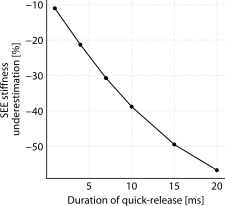

In [12]:
#| label: suppfig-ksee-qr-duration
#| fig-cap: Relationship between quick-release duration and SEE stiffness understimation. When the
#|   duration of the quick-release increases, the underestimation of SEE stiffness increases.

# %% Imports
import os, pickle, sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.close('all')

# Set directories
cwd = Path.cwd()
baseDir = cwd.parent
dataDir = baseDir / 'data'
funcDir = baseDir / 'analysis' / 'functions'
sys.path.append(str(funcDir))

# Custom import
import cust_fig, stats

plt.close('all')

#%% Make figure
cust_fig.style(plt, fontname='MinionPro', fontsize=11, grid=True)

fig = plt.figure(figsize=(15.92/2.54/2+51/600, (15.92/2-0.47)/2.54), constrained_layout=True) # 2:3 ratio (1254px x 1880px)
gs = fig.add_gridspec(1,1)
axs = np.array([fig.add_subplot(gs[i]) for i in range(0,gs.ncols*gs.nrows)])

#%% Extract parameters
mus = 'GMs1'
parDir = os.path.join(baseDir,'data','suppmat','')
orPar = pickle.load(open(os.path.join(dataDir,mus,'parameters',mus+'_OR.pkl'), 'rb'))

p_diff = []
for qr in ['QR01','QR04','QR07','QR10','QR15','QR20']:
    tmPar = pickle.load(open(parDir+mus+'_'+qr+'.pkl', 'rb'))[0]
    p_diff.append(stats.pdiff(tmPar['ksee'],orPar['ksee']))
    
#%% Plot
tStep = [int(x[2:]) for x in ['QR01','QR04','QR07','QR10','QR15','QR20']]
axs[0].plot(tStep,p_diff,'k.-')
axs[0].set_xlabel('Duration of quick-release [ms]')
axs[0].set_ylabel('SEE stiffness \n' +'underestimation [%]')

# %% Save
fig.align_labels() 
plt.show()
fig.savefig('s_servo_vs_lever.svg', bbox_inches="tight", pad_inches=0)
fig.savefig('s_servo_vs_lever.pdf', bbox_inches="tight", pad_inches=0)

# %% Checks
if check_size == True or check_size == 'True':
    cust_fig.report_axes_size(fig,axs)
    cust_fig.report_fig_size("s_ksee_qr_duration.svg") 
    cust_fig.report_fig_size("s_ksee_qr_duration.pdf") 
